## SETUP AND IMPORTS


In [ ]:

import os
import re
import random as rn
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## SEED CONTROL

In [2]:

SEED = 12345
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

## UTILITY FUNCTIONS

In [3]:
def preprocess(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    return scaled, scaler

def extract_VC_capacity(x_datasets, y_datasets, seq_len=5, hop=1, sample=10):
    from pandas import read_csv, DataFrame
    V, C = [], []
    x, y = [], []

    for x_data, y_data in zip(x_datasets, y_datasets):
        x_df = read_csv(x_data).dropna()
        x_df = x_df[['cycle', 'voltage_battery']]
        x_df = x_df[x_df['cycle'] != 0].reset_index(drop=True)

        y_df = read_csv(y_data).dropna()
        y_df['cycle_idx'] = y_df.index + 1
        y_df = y_df[['capacity', 'cycle_idx']].values.astype('float32')

        for i in range(len(y_df)):
            cy = x_df.cycle.unique()[i]
            df = x_df.loc[x_df['cycle'] == cy]
            cap = np.array([y_df[i, 0]])
            C.append(cap)
            df_C = DataFrame(C).values
            scaled_C, scaler_C = preprocess(df_C)
            scaled_C = scaled_C.astype('float32')

            le = len(df['voltage_battery']) % sample
            vTemp = df['voltage_battery'].to_numpy()
            if le != 0:
                vTemp = vTemp[0:-le]
            vTemp = np.reshape(vTemp, (len(vTemp)//sample, -1), order="F")
            vTemp = vTemp.mean(axis=0)
            V.append(vTemp)
            df_V = DataFrame(V).values
            scaled_V, _ = preprocess(df_V)
            scaled_V = scaled_V.astype('float32')

            VC_temp = np.concatenate([scaled_V, scaled_C], axis=1)

        data_len = np.int32(np.floor((len(y_df) - seq_len - 1) / hop)) + 1
        for i in range(data_len):
            x.append(VC_temp[(hop * i):(hop * i + seq_len)])
            y.append(scaled_C[hop * i + seq_len])
    return np.array(x), np.array(y), scaler_C

def evaluate_model(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n📊 {label} Results:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(8,5))
    plt.plot(y_true, label="True", lw=2)
    plt.plot(y_pred, label="Predicted", lw=2)
    plt.title(title)
    plt.xlabel("Cycle")
    plt.ylabel("Capacity")
    plt.legend()
    plt.show()

## DATA PREPARATION

In [ ]:
base_path = "data/NASA/" 

# Combine all charge/discharge data (train + test)
all_x_files = sorted(
    [os.path.join(base_path, "charge", subdir, f)
     for subdir in ["train", "test"]
     for f in os.listdir(os.path.join(base_path, "charge", subdir))
     if f.endswith(".csv")],
    key=lambda f: int(re.sub(r'\D', '', f))
)

all_y_files = sorted(
    [os.path.join(base_path, "discharge", subdir, f)
     for subdir in ["train", "test"]
     for f in os.listdir(os.path.join(base_path, "discharge", subdir))
     if f.endswith(".csv")],
    key=lambda f: int(re.sub(r'\D', '', f))
)

# Extract all data first
allX, allY, scaler = extract_VC_capacity(all_x_files, all_y_files, seq_len=5, hop=1, sample=10)
print("All data shape:", allX.shape, allY.shape)

# Perform 60-40 sequential split (NO shuffling)
split_idx = int(0.6 * len(allX))
trainX, testX = allX[:split_idx], allX[split_idx:]
trainY, testY = allY[:split_idx], allY[split_idx:]
print("Train shape:", trainX.shape, "Test shape:", testX.shape)

# Inverse scale for later comparison
inv_trainY = scaler.inverse_transform(trainY)
inv_testY = scaler.inverse_transform(testY)



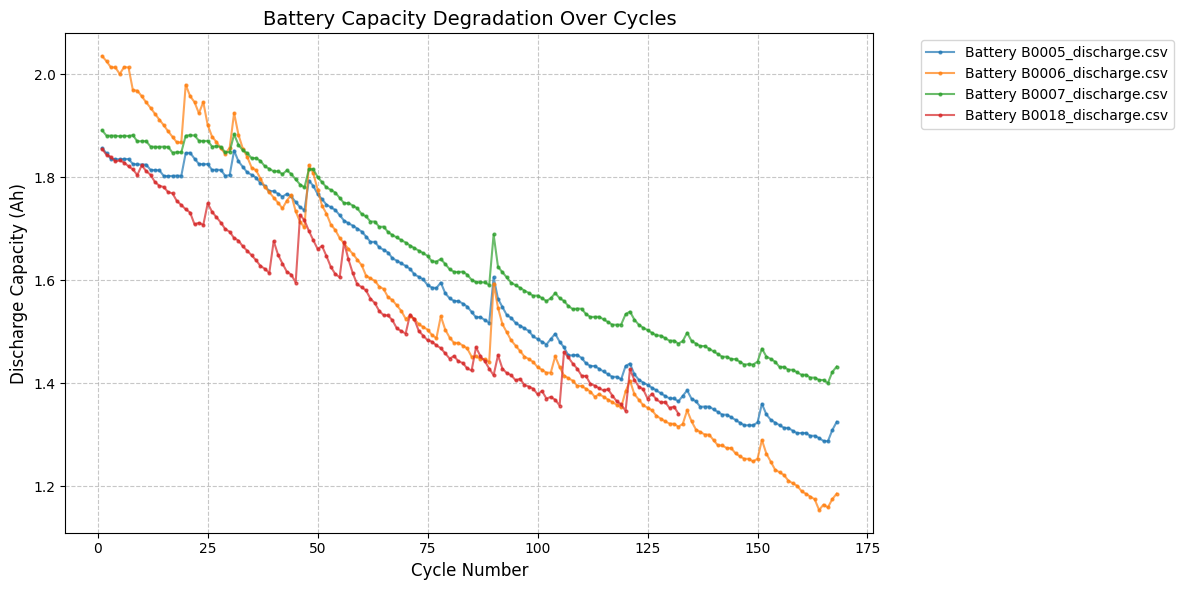

In [ ]:
def plot_battery_degradation(x_files, y_files):
    """Plot battery capacity degradation over cycles"""
    plt.figure(figsize=(12, 6))
    
    for x_file, y_file in zip(x_files, y_files):
        # Load discharge data for capacity
        y_df = pd.read_csv(y_file)
        capacity = y_df['capacity'].values
        cycles = range(1, len(capacity) + 1)
        
        # Plot individual battery
        plt.plot(cycles, capacity, 'o-', alpha=0.7, markersize=2, label=f'Battery {os.path.basename(y_file)}')

    plt.title('Battery Capacity Degradation Over Cycles', fontsize=14)
    plt.xlabel('Cycle Number', fontsize=12)
    plt.ylabel('Discharge Capacity (Ah)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot all batteries
plot_battery_degradation(all_x_files, all_y_files)


### 2. BASIC Deep machine models

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to torch tensors
trainX_t = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY_t = torch.tensor(trainY, dtype=torch.float32).to(device)
testX_t = torch.tensor(testX, dtype=torch.float32).to(device)
testY_t = torch.tensor(testY, dtype=torch.float32).to(device)

batch_size = 16
train_loader = DataLoader(TensorDataset(trainX_t, trainY_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(testX_t, testY_t), batch_size=batch_size, shuffle=False)




In [ ]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(BasicLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)  # Add batch norm
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        out = self.bn(out)   # normalize features
        out = self.fc(out)
        return out

class BasicGRU(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(BasicGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)  # Add batch norm
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take last time step
        out = self.bn(out)   # normalize features
        out = self.fc(out)
        return out

class CNN_LSTM(nn.Module):
    def __init__(self, input_size, conv_channels=64, kernel_size=3, lstm_hidden=32):
        super(CNN_LSTM, self).__init__()
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=conv_channels,
                              kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(conv_channels)  # Add batch norm after conv
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, batch_first=True)
        self.bn2 = nn.BatchNorm1d(lstm_hidden)    # Add batch norm after lstm
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)                # -> (batch, features, seq_len)
        x = self.conv(x)
        x = self.bn1(x)                       # normalize after conv
        x = self.relu(x)                      # -> (batch, conv_channels, seq_len)
        x = x.permute(0, 2, 1)               # -> (batch, seq_len, conv_channels)
        out, _ = self.lstm(x)                # -> (batch, seq_len, lstm_hidden)
        out = out[:, -1, :]                  # last time step
        out = self.bn2(out)                  # normalize features
        out = self.fc(out)                   # -> (batch, 1)
        return out

In [ ]:

# RMSE Loss

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


# Training function with scheduler

def train_model(model, train_loader, epochs=500, lr=1e-3, l1_lambda=1e-5, weight_decay=1e-4):
    model.to(device)
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            
            preds = model(xb)
            loss = criterion(preds, yb)
            
            # L1 regularization
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                loss = loss + l1_lambda * l1_norm
                
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} - RMSE Loss: {epoch_loss/len(train_loader.dataset):.6f}")
        
    return model

In [ ]:
input_size = trainX.shape[2]
deep_results = {}


# Basic LSTM

lstm_model = BasicLSTM(input_size)
train_model(lstm_model, train_loader)

lstm_model.eval()
with torch.no_grad():
    lstm_preds = lstm_model(testX_t).cpu().numpy()

# Use target scaler, not input scaler
inv_lstm_preds = scaler.inverse_transform(lstm_preds)
deep_results["Basic LSTM"] = evaluate_model(inv_testY, inv_lstm_preds, label="Basic LSTM")


# Basic GRU

gru_model = BasicGRU(input_size)
train_model(gru_model, train_loader)

gru_model.eval()
with torch.no_grad():
    gru_preds = gru_model(testX_t).cpu().numpy()

inv_gru_preds = scaler.inverse_transform(gru_preds)
deep_results["Basic GRU"] = evaluate_model(inv_testY, inv_gru_preds, label="Basic GRU")

# CNN + LSTM hybrid

cnn_lstm_model = CNN_LSTM(input_size)
train_model(cnn_lstm_model, train_loader)

cnn_lstm_model.eval()
with torch.no_grad():
    cnn_lstm_preds = cnn_lstm_model(testX_t).cpu().numpy()

inv_cnn_lstm_preds = scaler.inverse_transform(cnn_lstm_preds)
deep_results["CNN + LSTM"] = evaluate_model(inv_testY, inv_cnn_lstm_preds, label="CNN + LSTM")


Epoch 1/500 - RMSE Loss: 0.583469
Epoch 2/500 - RMSE Loss: 0.445323
Epoch 3/500 - RMSE Loss: 0.278230
Epoch 4/500 - RMSE Loss: 0.130592
Epoch 5/500 - RMSE Loss: 0.084437
Epoch 6/500 - RMSE Loss: 0.099991
Epoch 7/500 - RMSE Loss: 0.081150
Epoch 8/500 - RMSE Loss: 0.074090
Epoch 9/500 - RMSE Loss: 0.078277
Epoch 10/500 - RMSE Loss: 0.080252
Epoch 11/500 - RMSE Loss: 0.074446
Epoch 12/500 - RMSE Loss: 0.079611
Epoch 13/500 - RMSE Loss: 0.087390
Epoch 14/500 - RMSE Loss: 0.082386
Epoch 15/500 - RMSE Loss: 0.074036
Epoch 16/500 - RMSE Loss: 0.074587
Epoch 17/500 - RMSE Loss: 0.070295
Epoch 18/500 - RMSE Loss: 0.077807
Epoch 19/500 - RMSE Loss: 0.077451
Epoch 20/500 - RMSE Loss: 0.074813
Epoch 21/500 - RMSE Loss: 0.078309
Epoch 22/500 - RMSE Loss: 0.078318
Epoch 23/500 - RMSE Loss: 0.067000
Epoch 24/500 - RMSE Loss: 0.068545
Epoch 25/500 - RMSE Loss: 0.067701
Epoch 26/500 - RMSE Loss: 0.069706
Epoch 27/500 - RMSE Loss: 0.072374
Epoch 28/500 - RMSE Loss: 0.078939
Epoch 29/500 - RMSE Loss: 0.0

## RESULTS SUMMARY


=== Summary of All Models  ===


,MAE,RMSE,MAPE
Basic LSTM,0.040204,0.055174,0.027078
Basic GRU,0.033524,0.046959,0.021898
CNN + LSTM,0.036751,0.056047,0.024596


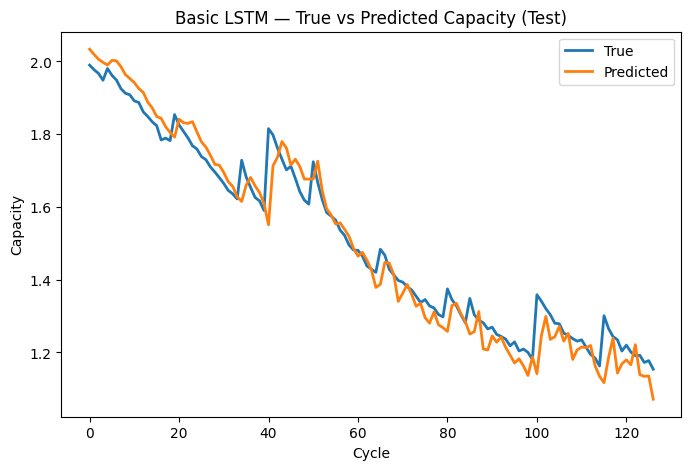

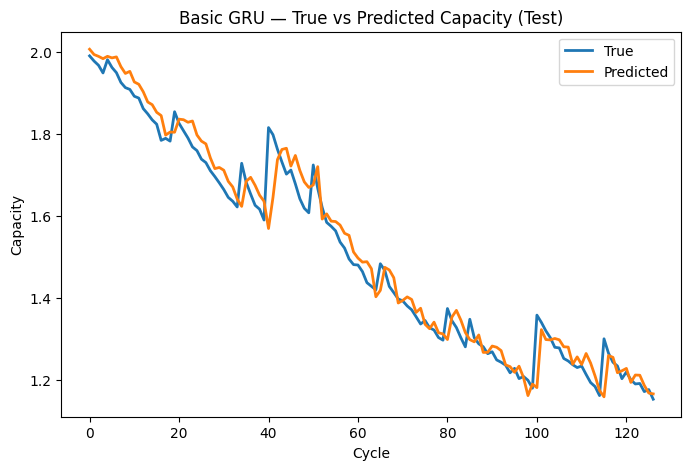

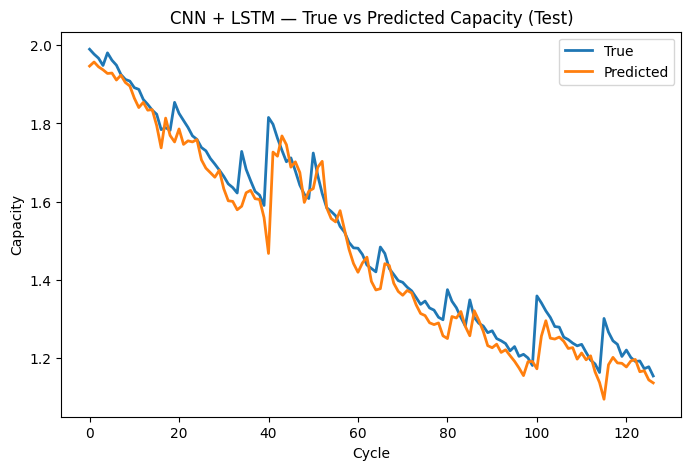

In [ ]:
import pandas as pd


# Store trained models

loaded_models = {
    "Basic LSTM": lstm_model,
    "Basic GRU": gru_model,
    "CNN + LSTM": cnn_lstm_model
}

all_results_torch = {**deep_results}
results_table_torch = pd.DataFrame(all_results_torch).T
print("\n=== Summary of All Models  ===")
display(results_table_torch)


# Plot test true vs predicted for all deep models using the existing plot_results function.
deep_preds = {
    "Basic LSTM": inv_lstm_preds,
    "Basic GRU": inv_gru_preds,
    "CNN + LSTM": inv_cnn_lstm_preds
}

for name, preds in deep_preds.items():
    try:
        plot_results(inv_testY, preds, f"{name} — True vs Predicted Capacity (Test)")
    except NameError as e:
        print(f"Skipping {name}: variable not found ({e})")



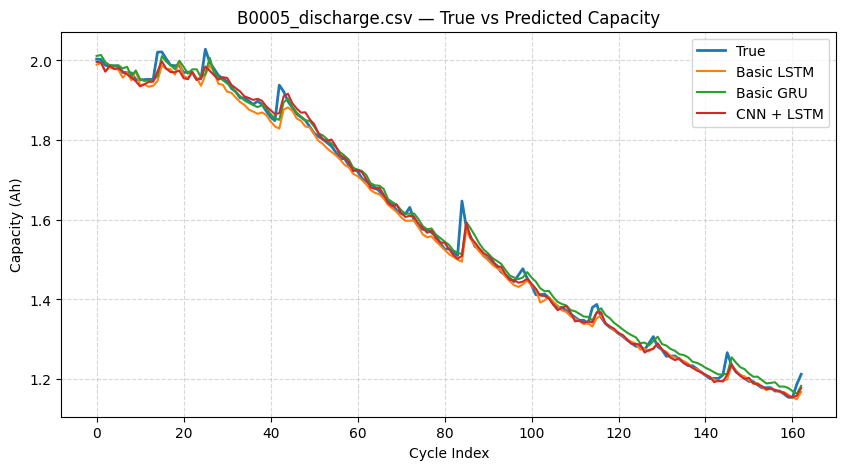

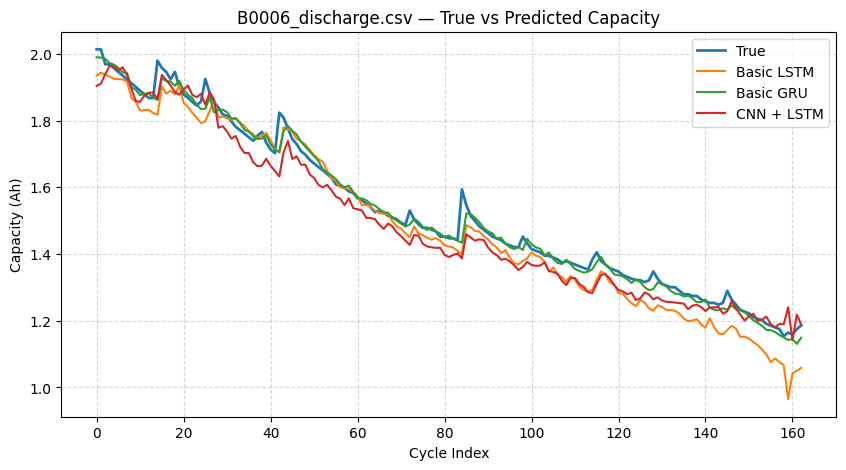

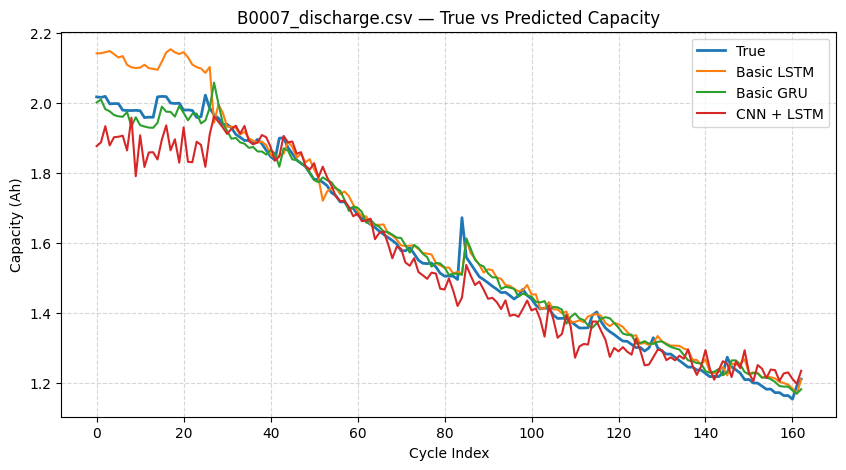

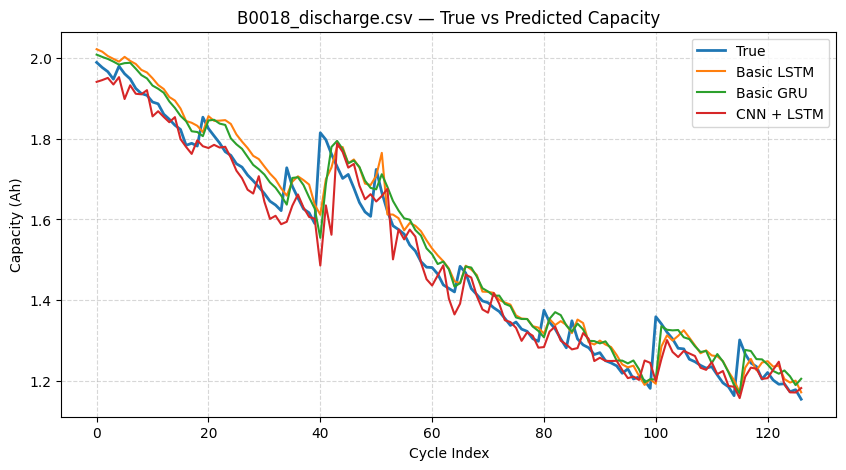

In [ ]:
def plot_per_battery(x_files, y_files, models, scaler, seq_len=5, hop=1, sample=10):
    """
    Plots true vs predicted capacity per battery for all models.
    
    Args:
        x_files (list): list of charge CSV files
        y_files (list): list of discharge CSV files
        models (dict): dict of model_name -> model instance
        scaler (sklearn scaler): scaler used for target inversion
    """
    num_batteries = len(y_files)
    
    for i, (x_file, y_file) in enumerate(zip(x_files, y_files)):
        # Extract data for this battery
        x_data, y_data, _ = extract_VC_capacity([x_file], [y_file], seq_len=seq_len, hop=hop, sample=sample)
        
        # Inverse scale true values
        y_true_inv = scaler.inverse_transform(y_data)
        
        plt.figure(figsize=(10,5))
        plt.plot(y_true_inv, label="True", linewidth=2)
        
        for name, model in models.items():
            model.eval()
            with torch.no_grad():
                x_t = torch.tensor(x_data, dtype=torch.float32).to(device)
                preds = model(x_t).cpu().numpy()
            preds_inv = scaler.inverse_transform(preds)
            plt.plot(preds_inv, label=name)
        
        plt.title(f"{os.path.basename(y_file)} — True vs Predicted Capacity")
        plt.xlabel("Cycle Index")
        plt.ylabel("Capacity (Ah)")
        plt.legend()
        plt.grid(True, alpha=0.5, linestyle="--")
        plt.show()

# Combine train + test batteries
plot_per_battery(all_x_files, all_y_files, loaded_models, scaler)
